In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Preparation

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


# Model Architecture

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, 
                     bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [4]:
class Bottleneck(nn.Module): 
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

적절한 Block type과 layer 수, 그리고 최종적으로 분류할 class 갯수를 받아 ResNet architecture를 구현

In [5]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
     

# Experiment Preparation

In [6]:
from utils.experiment import *
from utils.report import *
from utils.plot import *

In [7]:
def experiment(partition, args):
  
    net = net = ResNet(block=BasicBlock, layers=(args.layers,args.layers,args.layers,args.layers),
                        num_classes=100, zero_init_residual=args.zero_init_residual)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
     

# Experiment

In [8]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_n_layers_lr"

# ====== Model ====== #
#args.block = BasicBlock
args.layers = 5 # (5,5,5,5)
args.zero_init_residual = False

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.005
args.epoch = 20

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #

name_var1 = 'layers'
name_var2 = 'lr'
list_var1 = [1, 5]
list_var2 = [0.001, 0.0001]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
        
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp2_n_layers_lr', layers=1, zero_init_residual=False, l2=1e-05, optim='Adam', lr=0.001, epoch=20, train_batch_size=256, test_batch_size=1024)
Epoch 0, Acc(train/val): 18.66/24.80, Loss(train/val) 3.42/3.06. Took 3.46 sec
Epoch 1, Acc(train/val): 33.13/32.16, Loss(train/val) 2.62/2.71. Took 3.13 sec
Epoch 2, Acc(train/val): 42.19/35.45, Loss(train/val) 2.19/2.60. Took 3.22 sec
Epoch 3, Acc(train/val): 50.49/37.52, Loss(train/val) 1.82/2.51. Took 3.26 sec
Epoch 4, Acc(train/val): 59.00/38.72, Loss(train/val) 1.47/2.51. Took 3.26 sec
Epoch 5, Acc(train/val): 67.52/38.82, Loss(train/val) 1.13/2.60. Took 3.21 sec
Epoch 6, Acc(train/val): 76.94/41.07, Loss(train/val) 0.79/2.71. Took 3.20 sec
Epoch 7, Acc(train/val): 84.73/38.52, Loss(train/val) 0.53/2.99. Took 3.15 sec
Epoch 8, Acc(train/val): 90.94/40.24, Loss(train/val) 0.33/3.01. Took 3.29 sec
Epoch 9, Acc(train/val): 95.67/40.53, Loss(train/val) 0.17/3.15. Took 3.31 sec
Epoch 10, Acc(train/val): 97.64/40.78, Loss(tra

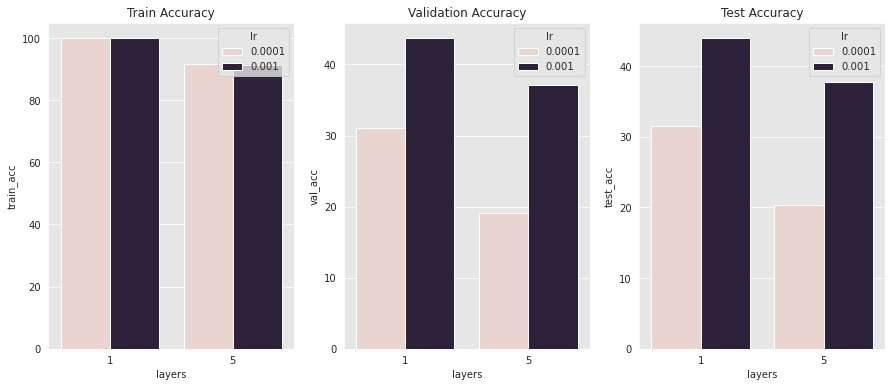

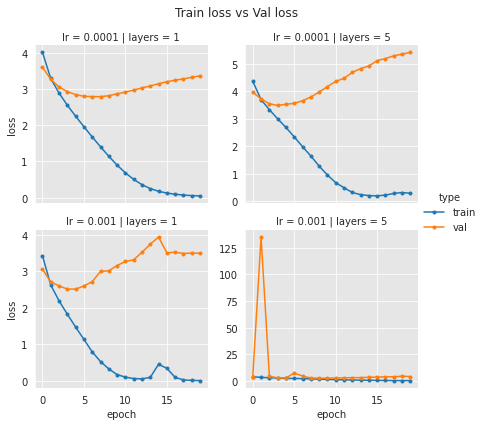

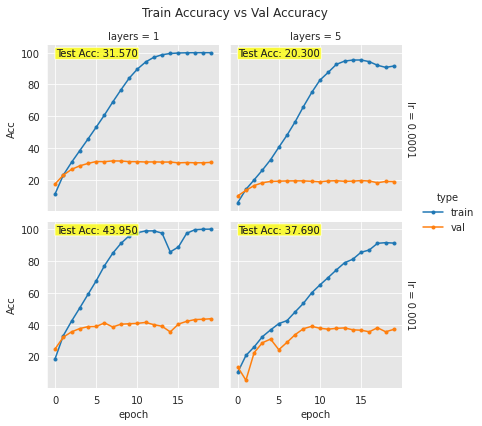

In [12]:
var1 = 'layers'
var2 = 'lr'
df = load_exp_result('exp2_')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) 
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) 